# Backtesting coursework

## Table of content


- [Imports](#imports)
- [Loading and pre-processing data](#loading)
- [Strategy implementation](#implementation)
- [Convert signal to position](#convert_signal_to_position)
- [Converted signals](#converted_signals)
- [Rolling table](#rolling_table)
- [Plot against benchmark](#benchmark)
- [Export to excel](#export_to_excel)
    - [Rolling table](#export_to_excel_rolling_table)
    - [Performance](#export_to_excel_performance)
    - [Merged df](#export_to_excel_merged_df)

## <a id="imports"></a>Imports

We start importing some handy packages as well as some custom python code that will be used later for good coding practice and consistency in our report, especially for graph formatting.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import helper

In [3]:
START_DATE='1969-01-01'
END_DATE='2023-05-18'

## <a id="loading"></a>Data loading and pre-processing

Here, we load the data. then we re-arrange the formatting of the dataframe and of the data. 

Regarding the dataframe formatting, we perform the following operations:
- set the dates as index
- rearrange the titles of the columns

Regarding the content of the dataframe (i.e. the data), we perform the following operations:
- convert index to datetime
- rearrange the returns (i.e. divide by 100, then substract 1)
- replace NaN with 0
- convert to log returns

Then, we perform some handy operations and store some variables for later:
- calculate the commodity market factor, which will serve as benchmark for backetsting
- get a list of all the assets
- compute the log of commodity market factor 

In [4]:
# Load data
raw_excess_returns = pd.read_excel('data.xlsx', sheet_name='Return Indices')

# Set 'Dates' column as index
raw_excess_returns.set_index('Dates', inplace=True)

# Replace consecutive spaces with underscores in column names
raw_excess_returns.columns = raw_excess_returns.columns.str.replace(r'\s+', '_').str.upper()

# Convert the index to datetime
raw_excess_returns.index = pd.to_datetime(raw_excess_returns.index)

raw_excess_returns = raw_excess_returns.loc[START_DATE:END_DATE]

# divide by 100 returns
raw_excess_returns = raw_excess_returns.div(100)-1

# replace NaN with 0
raw_excess_returns = raw_excess_returns.fillna(0)  

print(raw_excess_returns)

# get a list of all the assets
assets_list = raw_excess_returns.columns.values

# calculate the commodity market factor
commodity_market_factor = raw_excess_returns.mean(axis=1).to_frame()
commodity_market_factor.index.name = 'Date'
commodity_market_factor.rename(columns = {list(commodity_market_factor)[0]: 'commodity_market_factor'}, inplace = True)

# # Add the 'commodity_market_factor' column to the DataFrame
# raw_excess_returns['commodity_market_factor'] = commodity_market_factor

# convert returns to log returns
excess_returns = np.log(1+raw_excess_returns)

log_commodity_market_factor = np.log(1+commodity_market_factor)

            LIVE_CATTLE_FUTR_AUG23  LEAN_HOGS_FUTURE_JUL23  \
Dates                                                        
1969-01-01                0.000000                0.000000   
1969-01-02               -0.008039                0.000000   
1969-01-03               -0.012534                0.000000   
1969-01-06               -0.012534                0.000000   
1969-01-07               -0.008039                0.000000   
...                            ...                     ...   
2023-05-12                7.591147               -0.904264   
2023-05-15                7.607013               -0.901824   
2023-05-16                7.592469               -0.901123   
2023-05-17                7.626844               -0.904012   
2023-05-18                7.653287               -0.903956   

            COFFEE_'C'_FUTURE_JUL23  CORN_FUTURE_JUL23  \
Dates                                                    
1969-01-01                 0.000000           0.000000   
1969-01-02         

<ipython-input-4-0a5d7abdd03a>:8: FutureWarning: The default value of regex will change from True to False in a future version.
  raw_excess_returns.columns = raw_excess_returns.columns.str.replace(r'\s+', '_').str.upper()
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


## <a id="implementation"></a>Strategy implementation

Here, we create a breakout strategy function called `high_low_breakout`. It takes as input two parameters: (i) dataframe of excess returns with date as index and assets as column, and (ii) a window. The function outputs a pandas dataframe of 1s (buy signal), 0s (hold signal) and -1s (sell signal), with date as index and assets as column.

The strategy consists in buying when an asset has maximum returns over a given window, selling when it has minimum over a given window, or holding otherwise.

In [4]:
def high_low_breakout(excess_returns, window=40):
    """
    Parameters:
        excess_returns (pandas.DataFrame)
        window (int)
        
    Returns:
        signals (pandas.Dataframe)
    """

    signals = pd.DataFrame(index=excess_returns.index, columns=excess_returns.columns)

    for timestamp in excess_returns.index:

        for ticker in excess_returns.columns:
            signal = 0 # No signal (yet)
            current_excess_return = excess_returns.loc[timestamp, ticker]
            highest_return = excess_returns[ticker].rolling(window).max().loc[timestamp]
            lowest_return = excess_returns[ticker].rolling(window).min().loc[timestamp]

            if current_excess_return == highest_return:
                signal = 1 # Buy signal

            if current_excess_return == lowest_return:
                signal = -1 # Sell signal

            signals.loc[timestamp, ticker] = signal
    return signals

## <a id="implementation"></a>Run the strategy

In [5]:
signals = high_low_breakout(excess_returns, 10)
signals

,LIVE_CATTLE_FUTR_AUG23,LEAN_HOGS_FUTURE_JUL23,COFFEE_'C'_FUTURE_JUL23,CORN_FUTURE_JUL23,COTTON_NO.2_FUTR_JUL23,SOYBEAN_FUTURE_JUL23,SUGAR_#11_(WORLD)_JUL23,WHEAT_FUTURE(CBT)_JUL23,BRENT_CRUDE_FUTR_JUL23,COPPER_FUTURE_JUL23,...,SILVER_FUTURE_JUL23,PLATINUM_FUTURE_JUL23,WTI_CRUDE_FUTURE_JUN23,LME_NICKEL,LME_COPPER,LME_ALUMINIUM,LME_LEAD,LME_ZINC,COCOA_FUTURE_JUL23,HEATING_OIL
Date,,,,,,,,,,,,,,,,,,,,,
1969-01-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1969-01-02,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1969-01-03,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1969-01-06,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1969-01-07,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-12,0,0,-1,0,0,-1,0,0,0,0,...,-1,0,0,0,0,0,-1,0,0,0
2023-05-15,1,0,1,0,0,0,0,1,0,0,...,0,0,0,-1,0,0,-1,-1,0,0
2023-05-16,0,0,0,-1,0,-1,0,0,0,-1,...,-1,0,0,-1,-1,0,-1,-1,0,0


## <a id="convert_signal_to_position"></a>Convert signal to position

Next, we create a function that converts the 1s, 0s and -1s into strings 'buy', 'hold' and 'sell'. This function is purely for formatting purposes. It is used later for the backtester in order to provide more comprehensive outputs.

the function is called `convert_signal_to_position`. It takes a signals df as input and outputs a `converted_signals` df.

In [6]:
def convert_signal_to_position(signals):
    """
    Parameters:
        signals (pandas.DataFrame)
        
    Returns:
        converted_signals (pandas.Dataframe)
    """
    converted_signals = pd.DataFrame(index=signals.index, columns=signals.columns)
    for col in signals.columns:
        new_series = pd.Series(index=signals.index, dtype=int)
        position = ''
        state = 'hold'
        for idx,i in signals[col].items():
            if i == 0:
                state = 'hold'
                new_series[idx] = state
            elif i == 1:
                if position == 'buy':
                    state = 'hold'
                    new_series[idx] = state
                else:
                    position = 'buy'
                    state = 'buy'
                    new_series[idx] = state
            elif i == -1:
                if position == 'sell':
                    state = 'hold'
                    new_series[idx] = state
                else:
                    position = 'sell'
                    state = 'sell'
                    new_series[idx] = state
        converted_signals[col] = new_series
    return converted_signals

## <a id="converted_signals"></a>Converted signals

In [7]:
converted_signals = convert_signal_to_position(signals)
converted_signals

,LIVE_CATTLE_FUTR_AUG23,LEAN_HOGS_FUTURE_JUL23,COFFEE_'C'_FUTURE_JUL23,CORN_FUTURE_JUL23,COTTON_NO.2_FUTR_JUL23,SOYBEAN_FUTURE_JUL23,SUGAR_#11_(WORLD)_JUL23,WHEAT_FUTURE(CBT)_JUL23,BRENT_CRUDE_FUTR_JUL23,COPPER_FUTURE_JUL23,...,SILVER_FUTURE_JUL23,PLATINUM_FUTURE_JUL23,WTI_CRUDE_FUTURE_JUN23,LME_NICKEL,LME_COPPER,LME_ALUMINIUM,LME_LEAD,LME_ZINC,COCOA_FUTURE_JUL23,HEATING_OIL
Date,,,,,,,,,,,,,,,,,,,,,
1969-01-01,hold,hold,hold,hold,hold,hold,hold,hold,hold,hold,...,hold,hold,hold,hold,hold,hold,hold,hold,hold,hold
1969-01-02,hold,hold,hold,hold,hold,hold,hold,hold,hold,hold,...,hold,hold,hold,hold,hold,hold,hold,hold,hold,hold
1969-01-03,hold,hold,hold,hold,hold,hold,hold,hold,hold,hold,...,hold,hold,hold,hold,hold,hold,hold,hold,hold,hold
1969-01-06,hold,hold,hold,hold,hold,hold,hold,hold,hold,hold,...,hold,hold,hold,hold,hold,hold,hold,hold,hold,hold
1969-01-07,hold,hold,hold,hold,hold,hold,hold,hold,hold,hold,...,hold,hold,hold,hold,hold,hold,hold,hold,hold,hold
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-12,hold,hold,hold,hold,hold,sell,hold,hold,hold,hold,...,hold,hold,hold,hold,hold,hold,sell,hold,hold,hold
2023-05-15,buy,hold,buy,hold,hold,hold,hold,hold,hold,hold,...,hold,hold,hold,hold,hold,hold,hold,hold,hold,hold
2023-05-16,hold,hold,hold,hold,hold,hold,hold,hold,hold,hold,...,hold,hold,hold,hold,hold,hold,hold,hold,hold,hold


## <a id="rolling_table"></a>Rolling table
Now we create a rolling table which is the result of our backtester. this rolling table is a standard component that will serve as a basis tool for comparing any strategy.

In [8]:
def calculate_max_drawdown(returns):
    """
    Parameters:
        returns (pandas.Series)
        
    Returns:
        (float). refers to max drawdown
        drawdown_start_date (datetime64[ns]). format: YYYY-MM-DD.
        drawdown_end_date (datetime64[ns]). format: YYYY-MM-DD.
    """
    #check if the returns is a pandas.core.series.Series
    if not isinstance(returns, pd.Series):
        raise TypeError("returns must be a pandas.core.series.Series")
    drawdowns = []
    drawdown = returns[0]
    maxi = returns[0]
    drawdown_end_date = returns.index[0]
    drawdown_start_date = returns.index[0]

    for date,ret in returns.items():
        if ret > maxi: 
            maxi = ret
            drawdown_start_date = returns.index[0]

            
        if ret < drawdown: 
            drawdown = ret 
            drawdown_end_date = date
            
        drawdowns.append(drawdown)
        
    return -np.linalg.norm(maxi-drawdown), drawdown_start_date, drawdown_end_date
    
def calculate_kurtosis(returns):
    """
    Parameters:
        returns (pandas.Series)
        
    Returns:
        kurtosis (float)
    """
    
    #check if the returns is a pandas.core.series.Series
    if not isinstance(returns, pd.Series):
    raise TypeError("returns must be a pandas.core.series.Series")

    #calculate
    kurtosis = returns.kurtosis()

    #output
    return kurtosis

def calculate_skewness(returns):
    """
    Parameters:
        returns (pandas.Series)
        
    Returns:
        skewness (float)
    """
    
    #check if the returns is a pandas.core.series.Series
    if not isinstance(returns, pd.Series):
        raise TypeError("returns must be a pandas.core.series.Series")

    #calculate
    skewness = returns.skew()

    #output
    return skewness

def calculate_win_rate(returns):
    """
    Parameters:
        returns (pandas.Series)
        
    Returns:
        win_rate (float)
    """
    #check if the returns is a pandas.core.series.Series
    if not isinstance(returns, pd.Series):
        raise TypeError("returns must be a pandas.core.series.Series")

    #calculate
    win_rate = (returns > 0).sum() / len(returns)
    # Return the win rate
    return win_rate


def rolling_table(converted_signals):
    """
    Parameters:
        converted_signals (pandas.DataFrame)
        
    Returns:
        rolling_table (pandas.DataFrame)
    """
    
    cumulative_returns = pd.Series(0, index=converted_signals.index)
    rolling_table = []
    pending_tx = {}

    for ticker in converted_signals.columns:
        opened_or_closed = 'closed'
        # filter out hold to only keep buy/sell:
        for date, buy_or_sell in converted_signals[ticker][converted_signals[ticker] != 'hold'].items():
            if opened_or_closed == 'closed':
                opened_or_closed = 'opened'
                opened_date = date
                pending_tx[ticker] = opened_date
                rolling_table.append({
                    'Date': opened_date,
                    'Ticker': ticker,
                    'buy_or_sell': buy_or_sell,
                    'opened_or_closed': opened_or_closed,
                    'return': 0,
                    'max_drawdown': 0,
                    'max_drawdown_start_date': None,
                    'max_drawdown_end_date': None,
                    'kurtosis': 0,
                    'skewness': 0,
                    'win_rate': 0,
                })
            elif opened_or_closed == 'opened':

                opened_or_closed = 'closed'
                opened_date = pending_tx[ticker]
                closed_date = date
                rolling_table.append({
                    'Date': closed_date,
                    'Ticker': ticker,
                    'buy_or_sell': buy_or_sell,
                    'opened_or_closed': opened_or_closed,
                    'return': excess_returns[ticker].loc[opened_date:closed_date].sum(),
                    'max_drawdown': calculate_max_drawdown(excess_returns[ticker].loc[opened_date:closed_date])[0],
                    'max_drawdown_start_date': calculate_max_drawdown(excess_returns[ticker].loc[opened_date:closed_date])[1],
                    'max_drawdown_end_date': calculate_max_drawdown(excess_returns[ticker].loc[opened_date:closed_date])[2],
                    'kurtosis': calculate_kurtosis(excess_returns[ticker].loc[opened_date:closed_date]),
                    'skewness': calculate_skewness(excess_returns[ticker].loc[opened_date:closed_date]),
                    'win_rate': calculate_win_rate(excess_returns[ticker].loc[opened_date:closed_date]),
                })
                del pending_tx[ticker]


    rolling_table = pd.DataFrame(rolling_table)
    rolling_table = rolling_table.sort_values(by='Date', ascending=True).reset_index(drop=True)
    rolling_table['cumulative return'] = rolling_table['return'].cumsum()
    return rolling_table
rolling_table = rolling_table(converted_signals)
rolling_table.head(30)

,Date,Ticker,buy_or_sell,opened_or_closed,return,max_drawdown,max_drawdown_start_date,max_drawdown_end_date,kurtosis,skewness,win_rate,cumulative return
0,1969-01-14,COPPER_FUTURE_JUL23,sell,opened,0.000000,0.000000,NaT,NaT,0.000000,0.000000,0.000000,0.000000
1,1969-01-14,WTI_CRUDE_FUTURE_JUN23,sell,opened,0.000000,0.000000,NaT,NaT,0.000000,0.000000,0.000000,0.000000
2,1969-01-14,LME_COPPER,sell,opened,0.000000,0.000000,NaT,NaT,0.000000,0.000000,0.000000,0.000000
3,1969-01-14,PLATINUM_FUTURE_JUL23,sell,opened,0.000000,0.000000,NaT,NaT,0.000000,0.000000,0.000000,0.000000
4,1969-01-14,LME_ALUMINIUM,sell,opened,0.000000,0.000000,NaT,NaT,0.000000,0.000000,0.000000,0.000000
5,1969-01-14,LME_ZINC,sell,opened,0.000000,0.000000,NaT,NaT,0.000000,0.000000,0.000000,0.000000
6,1969-01-14,BRENT_CRUDE_FUTR_JUL23,sell,opened,0.000000,0.000000,NaT,NaT,0.000000,0.000000,0.000000,0.000000
7,1969-01-14,GASOLINE_RBOB_FUT_JUN23,sell,opened,0.000000,0.000000,NaT,NaT,0.000000,0.000000,0.000000,0.000000
8,1969-01-14,COFFEE_'C'_FUTURE_JUL23,sell,opened,0.000000,0.000000,NaT,NaT,0.000000,0.000000,0.000000,0.000000
9,1969-01-14,NATURAL_GAS_FUTR_JUN23,sell,opened,0.000000,0.000000,NaT,NaT,0.000000,0.000000,0.000000,0.000000


## <a id="benchmark"></a>Plot against benchmark
Here we plot the performance returns against the benchmark

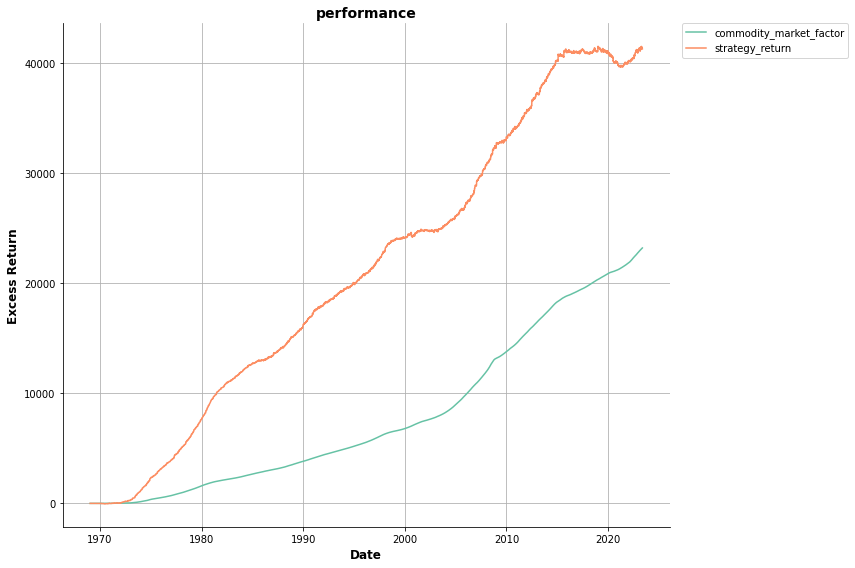

In [9]:
performance = pd.DataFrame(rolling_table.groupby('Date')['return'].sum())
performance.rename(columns = {list(performance)[0]: 'strategy_return'}, inplace = True)

helper.plot_df(pd.merge(commodity_market_factor.cumsum(), performance.cumsum(), on='Date'), title='performance')

We can see that the strategy performs better than the benchmark.

## <a id="export_to_excel"></a>Export to excel 

### <a id="export_to_excel_rolling_table"></a>Export to excel the rolling table DataFrame
Exporting the rolling_table isn an excel file called `rolling_table`

In [24]:
try:
    rolling_table.to_excel('rolling_table.xlsx')
    print("Excel file created successfully.")
except:
    print("ERROR: Could not create excel file.")

<ipython-input-24-72e13284f56b>:8: UserWarning: Pandas requires version '1.4.3' or newer of 'xlsxwriter' (version '1.3.8' currently installed).
  rolling_table.to_excel('rolling_table.xlsx')


Excel file created successfully.


### <a id="export_to_excel_performance"></a>Export to excel the performance DataFrame
Exporting the strategy cumulative returns in an excel file called `performance`

In [25]:
try:
    performance.to_excel('performance.xlsx')
    print("Excel file created successfully.")
except:
    print("ERROR: Could not create excel file.")

<ipython-input-25-df0d28b025e4>:2: UserWarning: Pandas requires version '1.4.3' or newer of 'xlsxwriter' (version '1.3.8' currently installed).
  performance.to_excel('performance.xlsx')


Excel file created successfully.


### <a id="export_to_excel_merged_df"></a>Export to excel the merged_df DataFrame
Merging our strategy cumulative returns with the benchmark cumulative returns, then exporting it in an excel file called `merged_df`

In [26]:
merged_df = pd.merge(commodity_market_factor.cumsum(), performance.cumsum(), on='Date')
try:
    merged_df.to_excel('merged_df.xlsx')
    print("Excel file created successfully.")
except:
    print("ERROR: Could not create excel file.")

<ipython-input-26-98095722a5e5>:3: UserWarning: Pandas requires version '1.4.3' or newer of 'xlsxwriter' (version '1.3.8' currently installed).
  merged_df.to_excel('merged_df.xlsx')


Excel file created successfully.


[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
